# Breakpoints

In [6]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [7]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Breakpoints for human approval


In [8]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


def convert_to_binary(number: int, bits: int = 8) -> str:
    """Converts a decimal integer to its two's complement binary representation.

    Args:
        number: The decimal integer to convert.
        bits: The number of bits for the binary representation.
    """
    if number >= 0:
        # For positive numbers, use standard binary conversion
        return bin(number)[2:].zfill(bits)
    else:
        # For negative numbers, calculate two's complement
        return bin((1 << bits) + number)[2:]

def calculate_twos_complement(binary_string: str) -> str:
    """Calculates the two's complement of a binary string.

    Args:
        binary_string: The binary string (e.g., '00000101').
    """
    bits = len(binary_string)
    # Invert the bits
    inverted = ''.join(['1' if b == '0' else '0' for b in binary_string])
    # Add 1
    inverted_int = int(inverted, 2)
    twos_comp_int = inverted_int + 1
    # Convert back to binary and handle overflow
    return bin(twos_comp_int)[2:].zfill(bits)[-bits:]

def add_twos_complement_binaries(bin1: str, bin2: str) -> str:
    """Adds two two's complement binary strings.

    Args:
        bin1: The first binary string.
        bin2: The second binary string.
    """
    bits = len(bin1)
    sum_val = int(bin1, 2) + int(bin2, 2)
    # Handle overflow by taking the last 'bits' number of bits
    result = sum_val & ((1 << bits) - 1)
    return bin(result)[2:].zfill(bits)

def convert_from_twos_complement(binary_string: str) -> int:
    """Converts a two's complement binary string back to a decimal integer.

    Args:
        binary_string: The two's complement binary string.
    """
    bits = len(binary_string)
    val = int(binary_string, 2)
    # If the most significant bit is 1, it's a negative number
    if (val & (1 << (bits - 1))) != 0:
        val = val - (1 << bits)
    return val


tools = [
    add, 
    multiply, 
    divide, 
    convert_to_binary, 
    calculate_twos_complement, 
    add_twos_complement_binaries,
    convert_from_twos_complement
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

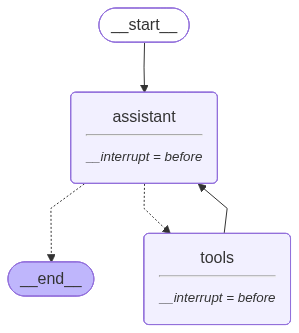

In [9]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant", "tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Input
initial_input = {"messages": HumanMessage(content="Convert 100 to its two's complement binary representation.")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Convert 100 to its two's complement binary representation.


In [11]:
state = graph.get_state(thread)
state.next

('assistant',)

In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Convert 100 to its two's complement binary representation.
================================== Ai Message ==================================
Tool Calls:
  convert_to_binary (call_nmGQSi3eiu2ASzpln7pNIVBM)
 Call ID: call_nmGQSi3eiu2ASzpln7pNIVBM
  Args:
    number: 100


In [ ]:
initial_input = {"messages": HumanMessage(content="Convert 100 to its two's complement binary representation.")}
thread = {"configurable": {"thread_id": "multi_break_v2"}} 

# Run until first breakpoint
print("Running until first breakpoint")

async for event in graph.astream(initial_input, thread, stream_mode="values"):
   
    if event.get('messages'):
        print("Event received:", event['messages'][-1].type)
    if event.get('__interrupt__'): 
         break
print("Paused before assistant")
state_before_assistant = await graph.aget_state(thread)
print(f"Next node to execute: {state_before_assistant.next}")


# First Resume
print("\n Resuming 1st time")

async for event in graph.astream(None, thread, stream_mode="values"):
     if event.get('messages'):
          print("Assistant proposed:", end=" ")
          event['messages'][-1].pretty_print()
     if event.get('__interrupt__'):
         break 
print("Paused before tools")
state_before_tools = await graph.aget_state(thread)
print(f"Next node to execute: {state_before_tools.next}")



print("\nAssistant wanted tool call:")
state_before_tools.values['messages'][-1].pretty_print() 
user_approval = input("Do you want to call the tool? (yes/no): ")


# Second Resume
if user_approval.lower() == "yes":
    print("\n--- Resuming 2nd time")
    
    async for event in graph.astream(None, thread, stream_mode="values"):
        if event.get('messages'):
             print("Event received:", end=" ")
             event['messages'][-1].pretty_print()
    print("\nGraph finished")
else:
    print("Operation cancelled by user before tool execution.")


Running until first breakpoint
Event received: human
Paused before assistant
Next node to execute: ('assistant',)

 Resuming 1st time
Assistant proposed: ================================ Human Message =================================

Convert 100 to its two's complement binary representation.
Assistant proposed: ================================== Ai Message ==================================
Tool Calls:
  convert_to_binary (call_4akEzipP5FMfEUk4KF5v2XhN)
 Call ID: call_4akEzipP5FMfEUk4KF5v2XhN
  Args:
    number: 100
Paused before tools
Next node to execute: ('tools',)

Assistant wanted tool call:
================================== Ai Message ==================================
Tool Calls:
  convert_to_binary (call_4akEzipP5FMfEUk4KF5v2XhN)
 Call ID: call_4akEzipP5FMfEUk4KF5v2XhN
  Args:
    number: 100

--- Resuming 2nd time
Event received: ================================== Ai Message ==================================
Tool Calls:
  convert_to_binary (call_4akEzipP5FMfEUk4KF5v2XhN)
 

### Breakpoints with LangGraph API

In [17]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [18]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [19]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b8cec5bb-b009-4b39-810e-9add099b3afd'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CV0oql1XFAVbKmHp4qUe0vPkYGPHG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': Non

In [20]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CV0oql1XFAVbKmHp4qUe0vPkYGPHG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--e91ab8e9-c9e7-4ac6-b470-2f8203d9a9ac-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_vPlMuRezdH1ngvX8e3kZObhA', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 